In [1]:
import intake
from easygems import healpix as egh
import healpy as hp
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime
from healpix_plot import get_listed_colormap, get_diverging_colormap

### load from catalog

In [3]:
current_location = "NERSC"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

In [4]:
list (cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'scream_ne120_inst',
 'tracking',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

### defining parameters

In [6]:
# Convert cftime to standard datetime64
from datetime import datetime

def convert_time(time_array):
    if hasattr(time_array[0], 'year'):  # It's a cftime object
        return np.array([np.datetime64(datetime(t.year, t.month, t.day, t.hour)) 
                         for t in time_array])
    return time_array

In [7]:
# analysis-specific user seetings
RADII = np.arange(5, 0., -1.5)    # Radius around MCS location in degrees
lat_bounds = (-20, 20)          # Latitude bounds for the tropics
catalog_params = {'zoom': 8}

In [8]:

ds_scream = cat["scream_ne120"](**catalog_params).to_dask().\
    pipe(egh.attach_coords)
ds_scream

<xarray.Dataset> Size: 2TB
Dimensions:          (time: 3168, cell: 786432, level: 25)
Coordinates:
  * time             (time) object 25kB 2019-08-01 03:00:00 ... 2020-09-01 00...
    lat              (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    lon              (cell) float64 6MB 45.0 45.18 44.82 ... 315.2 314.8 315.0
    lev              (level) int64 200B dask.array<chunksize=(4,), meta=np.ndarray>
    crs              int64 8B 0
  * cell             (cell) int64 6MB 0 1 2 3 4 ... 786428 786429 786430 786431
Dimensions without coordinates: level
Data variables: (12/39)
    clt              (time, cell) float32 10GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    hflsd            (time, cell) float32 10GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    hfssd            (time, cell) float32 10GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    huss             (time, cell) float32 10GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    lwcre            (time, cell) float32 10GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    pr               (time, cell) float32 10GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    ...               ...
    omega            (time, level, cell) float32 249GB dask.array<chunksize=(24, 4, 65536), meta=np.ndarray>
    qall             (time, level, cell) float32 249GB dask.array<chunksize=(24, 4, 65536), meta=np.ndarray>
    ta               (time, level, cell) float32 249GB dask.array<chunksize=(24, 4, 65536), meta=np.ndarray>
    ua               (time, level, cell) float32 249GB dask.array<chunksize=(24, 4, 65536), meta=np.ndarray>
    va               (time, level, cell) float32 249GB dask.array<chunksize=(24, 4, 65536), meta=np.ndarray>
    zg               (time, level, cell) float32 249GB dask.array<chunksize=(24, 4, 65536), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          3
    averaging_frequency_units:    nhours
    averaging_type:               AVERAGE
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

In [9]:
ds_scream = ds_scream.assign_coords(time=convert_time(ds_scream.time.values))

In [10]:
ds_scream_tropics = ds_scream.where((ds_scream['lat'] > lat_bounds[0]-RADII.max()) &
    (ds_scream['lat'] < lat_bounds[1]+RADII.max()), drop=True)
# Get the lat/lon coordinates of the healpix grid
hp_grid = ds_scream[['lat', 'lon']].compute()
# Get land-sea-mask
lf = ds_scream['LANDFRAC']
ocean_mask = lf.where(lf==0).compute()

### Read stats and subsample

In [11]:
root_dir = '/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/'
mcs_trackstats_scream = xr.open_dataset(root_dir + 'stats/mcs_tracks_final_20190801.0000_20200901.0000.nc')

In [12]:
mcs_trackstats_scream

<xarray.Dataset> Size: 58GB
Dimensions:                  (tracks: 56487, times: 650, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 452kB 0 1 2 3 ... 56484 56485 56486
  * times                    (times) int64 5kB 0 1 2 3 4 ... 645 646 647 648 649
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/63)
    track_duration           (tracks) int32 226kB ...
    start_status             (tracks) float64 452kB ...
    end_status               (tracks) float64 452kB ...
    start_basetime           (tracks) datetime64[ns] 452kB ...
    end_basetime             (tracks) datetime64[ns] 452kB ...
    start_split_cloudnumber  (tracks) float64 452kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 294MB ...
    movement_distance        (tracks, times) float32 147MB ...
    movement_speed           (tracks, times) float32 147MB ...
    movement_theta           (tracks, times) float32 147MB ...
    movement_distance_x      (tracks, times) float32 147MB ...
    movement_distance_y      (tracks, times) float32 147MB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Mon May  5 11:14:12 2025
    startdate:                    20190801.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [13]:
# Subsample relevant information
subset_mcs_stats_scream = mcs_trackstats_scream[
    ['start_split_cloudnumber', 'start_basetime', 'base_time','meanlat', 'meanlon',
     'mcs_duration','meanlon_smooth', 'meanlat_smooth',]
    ].compute()



In [14]:
# Select all tracks that don't start as a splitter 
mcs_tracks_triggered_scream = subset_mcs_stats_scream.where(
    np.isnan(subset_mcs_stats_scream["start_split_cloudnumber"]), drop=True,
    )


In [15]:
## Choose raw or smoothed lon/lat
latvar = 'meanlat_smooth'
lonvar = 'meanlon_smooth'

# Save the start location of the tracks
mcs_tracks_triggered_scream['start_lat'] = mcs_tracks_triggered_scream[latvar].isel(times=0)
mcs_tracks_triggered_scream['start_lon'] = mcs_tracks_triggered_scream[lonvar].isel(times=0)

In [16]:
# Convert to DataFrame for more reliable filtering
df = mcs_tracks_triggered_scream.to_dataframe()

# Apply filters with pandas 
filtered_df = df[
    (df['start_lat'] > lat_bounds[0]) & 
    (df['start_lat'] < lat_bounds[1]) &
    (df[latvar] > lat_bounds[0]) & 
    (df[lonvar] < lat_bounds[1]) &
    df[latvar].notna() &  # Explicitly check for non-NaN values
    df[lonvar].notna()    # Explicitly check for non-NaN values
].copy()


# Now calculate the HEALPix indices
nside = egh.get_nside(hp_grid)
pixel_indices_smooth = hp.ang2pix(
    nside,
    filtered_df[lonvar].values,  # Use DataFrame values directly
    filtered_df[latvar].values,  # Use DataFrame values directly
    nest=True, 
    lonlat=True
)

filtered_df['trigger_idx'] = pixel_indices_smooth

In [17]:
filtered_df.head()

start_split_cloudnumber      start_basetime           base_time  \
tracks times                                                                    
5      0                          NaN 2019-08-01 01:00:00 2019-08-01 01:00:00   
       1                          NaN 2019-08-01 01:00:00 2019-08-01 02:00:00   
       2                          NaN 2019-08-01 01:00:00 2019-08-01 03:00:00   
       3                          NaN 2019-08-01 01:00:00 2019-08-01 04:00:00   
       4                          NaN 2019-08-01 01:00:00 2019-08-01 05:00:00   

                meanlat     meanlon  mcs_duration  meanlon_smooth  \
tracks times                                                        
5      0      11.355928 -127.199150          75.0     -127.199150   
       1      11.282460 -127.283554          75.0     -127.283554   
       2      13.321916 -125.578476          75.0     -127.914726   
       3      13.009742 -128.545898          75.0     -128.545898   
       4      14.252420 -128.628891          75.0     -128.628891   

              meanlat_smooth  start_lat  start_lon  trigger_idx  
tracks times                                                     
5      0           11.355928  11.355928 -127.19915       132591  
       1           11.282460  11.355928 -127.19915       132591  
       2           12.146101  11.355928 -127.19915       132976  
       3           13.009742  11.355928 -127.19915       133073  
       4           14.252420  11.355928 -127.19915       135843

### determine circular areas and remove land areas

In [18]:
def add_circular_trigger_areas_df(filtered_df, RADII, hp_grid, ocean_mask=None, remove_land=False):
    """DataFrame-optimized version of circular area calculation with optional land filtering
    
    Parameters:
    -----------
    filtered_df : pandas.DataFrame
        DataFrame with MCS track information
    RADII : np.ndarray
        Array of radii in degrees
    hp_grid : xarray.Dataset
        HEALPix grid with lat/lon information
    ocean_mask : xarray.DataArray, optional
        Ocean mask (0=land, non-NaN=ocean)
    remove_land : bool, default=False
        If True, filter out trigger areas that contain any land
    
    Returns:
    --------
    tuple
        (trigger_areas, filtered_df)
        - trigger_areas: Dictionary mapping (track_idx, radius) to pixel arrays
        - filtered_df: DataFrame filtered to ocean-only areas if remove_land=True
    """
    # Get HEALPix grid parameters
    nside = egh.get_nside(hp_grid)
    nest = True if egh.get_nest(hp_grid) else False
    
    # Create dictionary to store trigger areas
    trigger_areas = {}
    
    # For ocean filtering
    ocean_tracks = set()
    
    # Process tracks in batches for better memory management
    batch_size = 100
    total_tracks = len(filtered_df)
    
    for batch_start in range(0, total_tracks, batch_size):
        batch_end = min(batch_start + batch_size, total_tracks)
        print(f"Processing batch {batch_start//batch_size + 1}/{(total_tracks//batch_size) + 1}")
        
        # Get batch of trigger indices
        batch_df = filtered_df.iloc[batch_start:batch_end]
        
        # Process all radii for each track in the batch
        from concurrent.futures import ThreadPoolExecutor
        
        def process_track(row):
            idx = row.Index
            cell_idx = int(row.trigger_idx)
            
            # Store area indices per radius
            track_areas = {}
            is_ocean_track = True  # Assume ocean track until we find land
            
            # Process each radius (largest first for efficiency when filtering)
            for radius in sorted(RADII, reverse=True):
                # Get pixels within radius
                area_idxs = hp.query_disc(
                    nside, 
                    hp.pix2vec(nside, cell_idx, nest=nest), 
                    np.radians(radius),
                    inclusive=False, 
                    nest=nest
                )
                
                # Store result
                track_areas[(idx, radius)] = area_idxs
                
                # Check if this is a largest radius and we need to filter for ocean
                if remove_land and radius == max(RADII):
                    # Check if all areas are ocean
                    if ocean_mask is not None:
                        try:
                            # Get ocean mask values for these pixels
                            mask_values = ocean_mask.sel(cell=area_idxs).values
                            # If any are NaN, there's land in this area
                            if np.any(np.isnan(mask_values)):
                                is_ocean_track = False
                        except:
                            # If selection fails, be conservative and exclude
                            is_ocean_track = False
            
            return idx, track_areas, is_ocean_track
        
        # Process in parallel
        with ThreadPoolExecutor(max_workers=4) as executor:
            results = list(executor.map(process_track, batch_df.itertuples()))
        
        # Store results
        for idx, areas, is_ocean in results:
            # Store areas in the dictionary
            trigger_areas.update(areas)
            
            # Mark as ocean track if needed
            if is_ocean:
                ocean_tracks.add(idx)
    
    # Filter DataFrame if requested
    if remove_land:
        filtered_ocean_df = filtered_df.loc[list(ocean_tracks)].copy()
        print(f"Filtered from {len(filtered_df)} to {len(filtered_ocean_df)} ocean-only tracks")
        return trigger_areas, filtered_ocean_df
    
    return trigger_areas, filtered_df

In [ ]:
def extract_var_statistics_fast(trigger_areas, filtered_df, ds_variable, time_tolerance=pd.Timedelta('1H'), 
                              times_before_init=None, include_full_evolution=False):
    """Function to extract summary statistics for each area
    
    Parameters:
    -----------
    trigger_areas : dict
        Dictionary mapping (track_idx, radius) to pixel arrays
    filtered_df : pandas.DataFrame
        DataFrame with MCS track information
    ds_variable : xarray.DataArray
        Data variable to extract statistics from
    time_tolerance : pd.Timedelta, optional
        Tolerance for matching times (default: 1 hour)
    times_before_init : pd.Timedelta, optional
        If provided, extract data for this time period before each track's start time (initiation)
    include_full_evolution : bool, optional
        If True, include all times in the track's lifecycle after initiation (default: False)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing statistics for each track, radius, and time offset
    """
    results = []
    
    # Pre-calculate available times once (huge speedup)
    available_times = pd.DatetimeIndex(ds_variable.time.values)
    
    # Process in larger batches
    batch_size = 250
    
    # Extract the unique track IDs (ignoring time indices in case tracks are tuples)
    if isinstance(filtered_df.index[0], tuple):
        # If index is a tuple (track_id, time_idx), extract just the track IDs
        unique_track_ids = sorted(set([idx[0] for idx in filtered_df.index]))
    else:
        # Otherwise use the indices directly
        unique_track_ids = filtered_df.index.unique()
        
    total_tracks = len(unique_track_ids)
    
    for batch_start in range(0, total_tracks, batch_size):
        batch_end = min(batch_start + batch_size, total_tracks)
        batch_track_ids = unique_track_ids[batch_start:batch_end]
        
        print(f"Processing batch {batch_start//batch_size + 1}/{(total_tracks//batch_size) + 1}")
        
        # Create a dictionary to store all pixel indices for this batch
        all_pixels = {}
        track_times_map = {}
        
        # First gather all pixels and times needed for this batch
        for track_id in batch_track_ids:
            # Get all rows for this track ID (regardless of time index)
            if isinstance(filtered_df.index[0], tuple):
                # Find all rows where the first element of the index tuple matches track_id
                track_rows = filtered_df.loc[[idx for idx in filtered_df.index if idx[0] == track_id]]
                track_data = track_rows.iloc[0]  # Use first row for reference info
                
                # If we need full evolution, gather all base_times for this track
                if include_full_evolution:
                    track_base_times = pd.DatetimeIndex([pd.Timestamp(row['base_time']) for _, row in track_rows.iterrows()])
            else:
                track_data = filtered_df.loc[track_id]
                
                # For non-tuple indices, we don't have multiple times per track
                if include_full_evolution:
                    track_base_times = pd.DatetimeIndex([pd.Timestamp(track_data['base_time'])])
            
            # Get times needed for analysis
            analysis_times = []
            
            # 1. Add pre-convective times if requested
            if times_before_init is not None:
                # Get the initiation time of the MCS track
                init_time = pd.Timestamp(track_data['start_basetime'])
                start_time = init_time - times_before_init
                
                # Find all available times within this range
                preconv_times = available_times[(available_times >= start_time) & 
                                              (available_times <= init_time)]
                analysis_times.extend(preconv_times)
                
            # 2. Add full evolution times if requested
            if include_full_evolution:
                # Get all available times from the track's lifecycle
                if isinstance(filtered_df.index[0], tuple):
                    # For tuple indices, we need to find all timestamps in the dataset
                    # that match any of this track's base_times (within tolerance)
                    for base_time in track_base_times:
                        if time_tolerance is not None:
                            # Find closest time within tolerance
                            closest_idx = np.abs(available_times - base_time).argmin()
                            if abs(available_times[closest_idx] - base_time) <= time_tolerance:
                                analysis_times.append(available_times[closest_idx])
                        elif base_time in available_times:
                            analysis_times.append(base_time)
                else:
                    # For single index, just add the base_time
                    base_time = pd.Timestamp(track_data['base_time'])
                    if time_tolerance is not None:
                        closest_idx = np.abs(available_times - base_time).argmin()
                        if abs(available_times[closest_idx] - base_time) <= time_tolerance:
                            analysis_times.append(available_times[closest_idx])
                    elif base_time in available_times:
                        analysis_times.append(base_time)
            
            # 3. If neither pre-convective nor full evolution requested, just use base_time
            if not times_before_init and not include_full_evolution:
                request_time = pd.Timestamp(track_data['base_time'])
                
                # Find closest available time within tolerance
                if time_tolerance is not None:
                    closest_idx = np.abs(available_times - request_time).argmin()
                    time_diff = abs(available_times[closest_idx] - request_time)
                    if time_diff <= time_tolerance:
                        analysis_times.append(available_times[closest_idx])
                elif request_time in available_times:
                    analysis_times.append(request_time)
            
            # Skip if no valid times found
            if not analysis_times:
                continue
            
            # Store unique times for this track
            track_times_map[track_id] = pd.DatetimeIndex(sorted(set(analysis_times)))
            
            # Collect all pixels for each radius
            for radius in RADII:
                # Try different key formats depending on how trigger_areas is structured
                area_keys_to_try = [
                    (track_id, radius),  # Simple (track_id, radius) key
                    ((track_id, 0), radius)  # (track_id, time_idx=0, radius) key
                ]
                
                # Try each possible key format
                for area_key in area_keys_to_try:
                    if area_key in trigger_areas:
                        pixels = trigger_areas[area_key]
                        all_pixels[area_key] = pixels
                        break
        
        if not all_pixels:
            print("  No valid areas found in this batch")
            continue
            
        # Now fetch all data at once for this batch (MAJOR SPEEDUP)
        all_track_pixels = np.concatenate(list(all_pixels.values()))
        all_track_times = []
        for times in track_times_map.values():
            all_track_times.extend(times)
        all_track_times = list(set(all_track_times))
        
        # Get all data in one big selection
        try:
            data_chunk = ds_variable.sel(
                time=all_track_times,
                cell=np.unique(all_track_pixels)
            ).compute()
        except Exception as e:
            print(f"  Error fetching data: {e}")
            continue
        
        # Process statistics for each track, radius, and time
        for track_id in batch_track_ids:
            if track_id not in track_times_map:
                continue
                
            # Get all times for this track
            track_times = track_times_map[track_id]
            
            # Get track data (use first row if multiple exist)
            if isinstance(filtered_df.index[0], tuple):
                track_indices = [idx for idx in filtered_df.index if idx[0] == track_id]
                track_data = filtered_df.loc[track_indices[0]]
            else:
                track_data = filtered_df.loc[track_id]
            
            # Use start_basetime as the reference time for all time offsets
            reference_time = pd.Timestamp(track_data['start_basetime'])
            
            for radius in RADII:
                # Try different key formats
                area_key = None
                for key_to_try in [(track_id, radius), ((track_id, 0), radius)]:
                    if key_to_try in all_pixels:
                        area_key = key_to_try
                        break
                        
                if area_key is None:
                    continue
                    
                pixels = all_pixels[area_key]
                
                # Process each time point in the range
                for current_time in track_times:
                    # Calculate time offset in hours (negative = before init, positive = after init)
                    time_offset = (current_time - reference_time).total_seconds() / 3600
                    
                    # Extract just this area's data for this time
                    try:
                        area_data = data_chunk.sel(time=current_time, cell=pixels)
                        
                        # Calculate statistics
                        stats = {
                            'track': track_id,  # Store just the track ID, not the tuple
                            'radius': radius,
                            'matched_time': current_time,
                            'reference_time': reference_time,
                            'time_offset_hours': time_offset,
                            'mean': float(area_data.mean().values),
                            'median': float(np.nanmedian(area_data.values)),
                            'min': float(area_data.min().values),
                            'max': float(area_data.max().values),
                            'std': float(area_data.std().values),
                            'count': len(pixels),
                            'valid_count': int(np.sum(~np.isnan(area_data.values)))
                        }
                        results.append(stats)
                    except Exception as e:
                        print(f"  Error processing area {area_key} at time {current_time}: {e}")
                        continue
    
    # Convert to DataFrame
    result_df = pd.DataFrame(results)
    
    if len(result_df) > 0:
        # Add a column for relative time index (negative = before init, 0 = init, positive = after init)
        result_df['time_index'] = result_df['time_offset_hours'].round().astype(int)
    
    print(f"Processed {len(result_df)} track-radius-time combinations")
    return result_df

In [20]:
short_subset = filtered_df[(filtered_df.base_time > '2020-01-01T00:00:00')&(
    filtered_df.base_time < '2020-03-01T00:00:00') & (filtered_df[lonvar] < -120) & (filtered_df[lonvar] > -180)]

In [21]:
# Example usage with ocean filtering
print("Calculating trigger areas with ocean filtering...")
trigger_areas_subset, ocean_filtered_df_subset = add_circular_trigger_areas_df(
    short_subset, 
    RADII, 
    hp_grid,
    ocean_mask=ocean_mask,  # Pass the ocean mask
    remove_land=True        # Request land filtering
)


Calculating trigger areas with ocean filtering...
Processing batch 1/57
Processing batch 2/57
Processing batch 3/57
Processing batch 4/57
Processing batch 5/57
Processing batch 6/57
Processing batch 7/57
Processing batch 8/57
Processing batch 9/57
Processing batch 10/57
Processing batch 11/57
Processing batch 12/57
Processing batch 13/57
Processing batch 14/57
Processing batch 15/57
Processing batch 16/57
Processing batch 17/57
Processing batch 18/57
Processing batch 19/57
Processing batch 20/57
Processing batch 21/57
Processing batch 22/57
Processing batch 23/57
Processing batch 24/57
Processing batch 25/57
Processing batch 26/57
Processing batch 27/57
Processing batch 28/57
Processing batch 29/57
Processing batch 30/57
Processing batch 31/57
Processing batch 32/57
Processing batch 33/57
Processing batch 34/57
Processing batch 35/57
Processing batch 36/57
Processing batch 37/57
Processing batch 38/57
Processing batch 39/57
Processing batch 40/57
Processing batch 41/57
Processing batch

In [22]:
var='hflsd'
print("Extracting variable statistics...")
lhf_in_areas = extract_var_statistics_fast(
    trigger_areas_subset, 
    ocean_filtered_df_subset, 
    ds_scream_tropics[var],time_tolerance=None, times_before_init=pd.Timedelta('24H'),include_full_evolution=True
)

Extracting variable statistics...
Processing batch 1/1
Processed 4236 track-radius-time combinations


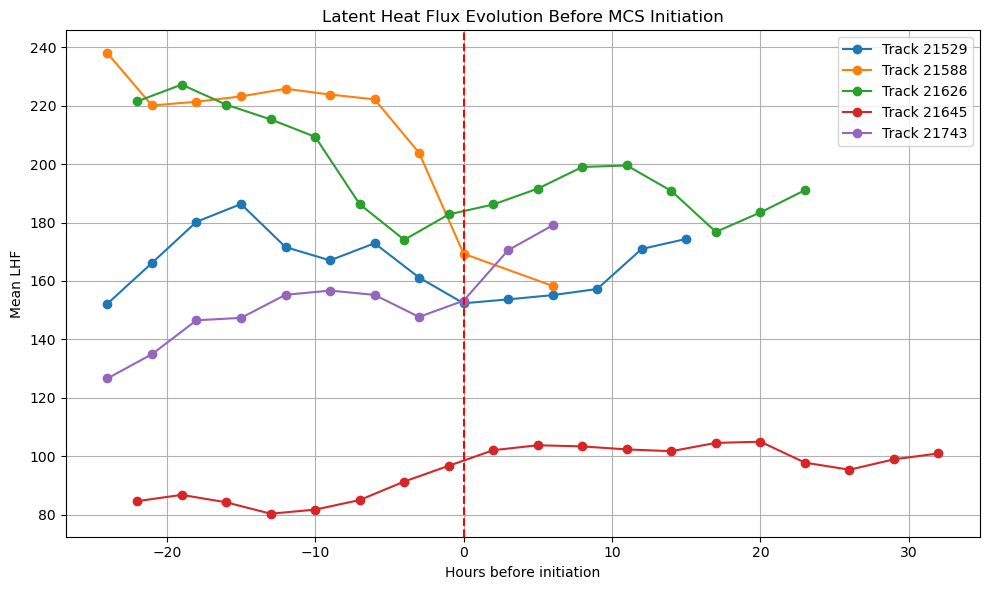

In [23]:
# Analyze how latent heat flux changes before MCS formation
fig, ax = plt.subplots(figsize=(10, 6))
for track in lhf_in_areas['track'].unique()[:5]:  # Show first 5 tracks
    track_data = lhf_in_areas[(lhf_in_areas['track'] == track) & 
                             (lhf_in_areas['radius'] == RADII[2])]
    if len(track_data) > 1:  # Make sure we have enough data points
        track_data = track_data.sort_values('time_index')
        ax.plot(track_data['time_offset_hours'], track_data['mean'], 
                marker='o', label=f'Track {track}')

ax.set_xlabel('Hours before initiation')
ax.set_ylabel('Mean LHF')
ax.set_title('Latent Heat Flux Evolution Before MCS Initiation')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.axvline(x=0, color='r', linestyle='--', label='Initiation')
plt.show()

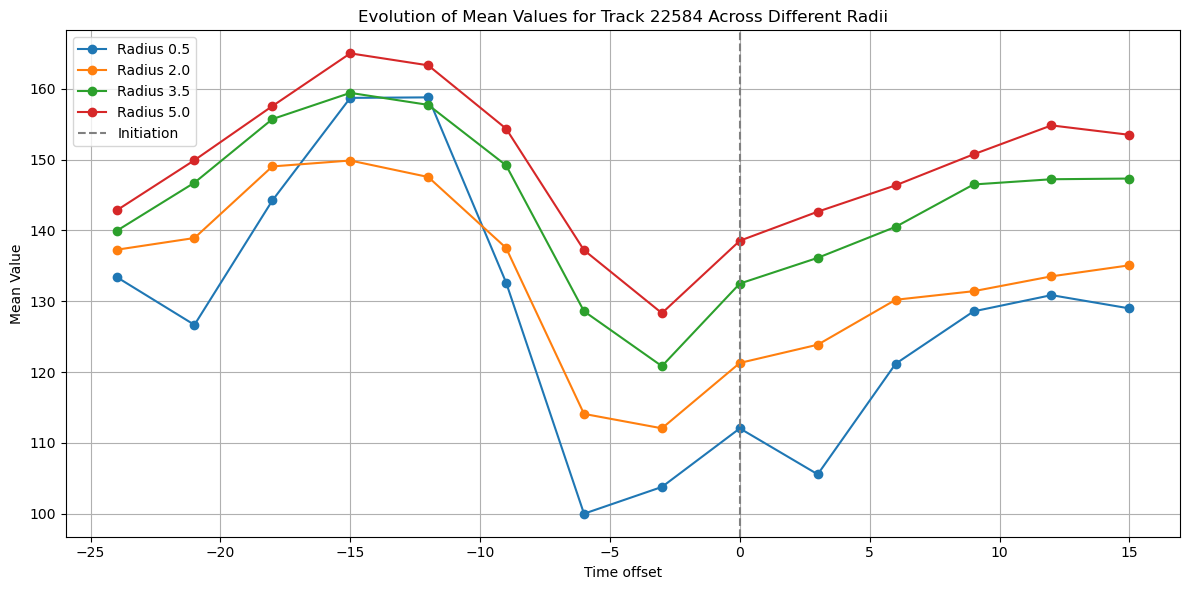

In [26]:
# Create the plot with preconvective time
plt.figure(figsize=(12, 6))

# Filter data for the specified track
track = lhf_in_areas['track'].unique()[10]
track_data = lhf_in_areas[(lhf_in_areas['track'] == track)].copy()

for radius in sorted(RADII):
    # Get data for this radius
    radius_subset = track_data[track_data['radius'] == radius]
    
    if len(radius_subset) == 0:
        continue
        
    # Sort by time index
    radius_subset = radius_subset.sort_values('time_offset_hours')
    
    # Plot mean values vs time
    plt.plot(radius_subset['time_offset_hours'], radius_subset['mean'], 
                marker='o', label=f'Radius {radius}')

# Add labels and title
plt.xlabel('Time offset')
plt.ylabel('Mean Value')
plt.title(f'Evolution of Mean Values for Track {track} Across Different Radii')
plt.axvline(x=0, color='gray', linestyle='--', label='Initiation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()